## Commuting Map construction


---

```
Reggio et al, Fast Partitioning of Pauli Strings into Commuting Families for Optimal Expectation Value Measurements of Dense Operators, 2023-06-07
```

```
Schmitz et al, Graph Optimization Perspective for Low-Depth Trotter-Suzuki Decomposition, 2023-05-26
```

In [5]:
from collections import OrderedDict

import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams.update({"font.serif": "Times New Roman"})

from pauli_op import Pauli2String,  PauliDecompose

In [6]:
# Load molecular hamiltonian from Pennylane Dataset
# https://pennylane.ai/qml/datasets_qchem/
MOLECULE_NAME = "LiH"

In [7]:
data = qml.data.load("qchem", molname=MOLECULE_NAME , basis="STO-3G", bondlength  = 2.1)[0]

In [8]:
Hamiltonian = data.hamiltonian

In [9]:
hamiltonian_basis = Hamiltonian.terms()[1]
qubits = len(Hamiltonian.wires)

In [10]:
# Convert to strings
p_strings = []
for p in hamiltonian_basis:
    p_strings.append(Pauli2String(p,qubits))

In [11]:
print(len(p_strings))
p_strings[:10]

631


['IIIIIIIIIIII',
 'ZIIIIIIIIIII',
 'IZIIIIIIIIII',
 'ZZIIIIIIIIII',
 'YZYIIIIIIIII',
 'YIYIIIIIIIII',
 'XZXIIIIIIIII',
 'XIXIIIIIIIII',
 'YZZZYIIIIIII',
 'YIZZYIIIIIII']

In [12]:
Z_family = []
X_family = []

P_strings = {}
for p in p_strings:
    P_strings[p] = PauliDecompose(p)
    type_s, z_st, x_st = PauliDecompose(p)
    if type_s == 0:
        Z_family.append(z_st)
    elif type_s ==1:
        X_family.append(x_st)
    else:
        Z_family.append(z_st)
        X_family.append(x_st)

In [13]:
re_Z_family = list(OrderedDict.fromkeys(Z_family))
re_X_family = list(OrderedDict.fromkeys(X_family))
z_dim = len(re_Z_family)
x_dim = len(re_X_family)


In [14]:
print(f"Reduce Z_family duplication:{len(Z_family)} -> {len(re_Z_family)}")
print(f"Reduce X_family duplication:{len(X_family)} -> {len(re_X_family)}")

Reduce Z_family duplication:619 -> 252
Reduce X_family duplication:552 -> 83


In [15]:
print(f"Basis dim: {len(p_strings)}")
print(f"Family dim: {z_dim*x_dim + z_dim + x_dim}")

Basis dim: 631
Family dim: 21251


In [16]:
df = pd.DataFrame.from_dict(P_strings, orient="index", columns = ["type", "Z", "X"])
df= df.sort_values("type")
df = df.replace("", None)
df["Znum"] = df["Z"].apply(lambda x: int(x.replace("Z", "1").replace("I", "0"),2) if x is not None else 0).astype(int)
df["Xnum"] = df["X"].apply(lambda x: int(x.replace("X", "1").replace("I", "0"),2) if x is not None else 0).astype(int)
df= df.sort_values(by=["type", "Znum", "Xnum"])
df.reset_index(inplace=True, names="Pstring")

In [17]:
df.tail(10)

,Pstring,type,Z,X,Znum,Xnum
621,YZZZZZZZIZYI,2,ZZZZZZZZIZZI,XIIIIIIIIIXI,4086,2050
622,YZZZZZZZZIYI,2,ZZZZZZZZZIZI,XIIIIIIIIIXI,4090,2050
623,YZZZZZZZYXZX,2,ZZZZZZZZZIZI,XIIIIIIIXXIX,4090,2061
624,YZZZZZZZZZYI,2,ZZZZZZZZZZZI,XIIIIIIIIIXI,4094,2050
625,ZYZZZZZZZZZY,2,ZZZZZZZZZZZZ,IXIIIIIIIIIX,4095,1025
626,YZZZZZZZZZYZ,2,ZZZZZZZZZZZZ,XIIIIIIIIIXI,4095,2050
627,YZZZZZZZYYZY,2,ZZZZZZZZZZZZ,XIIIIIIIXXIX,4095,2061
628,YZZZZZYYZZZY,2,ZZZZZZZZZZZZ,XIIIIIXXIIIX,4095,2097
629,YZZZYYZZZZZY,2,ZZZZZZZZZZZZ,XIIIXXIIIIIX,4095,2241
630,YZYYZZZZZZZY,2,ZZZZZZZZZZZZ,XIXXIIIIIIIX,4095,2817


In [18]:
zdf = df[["Znum"]].drop_duplicates()
xdf = df[["Xnum"]].drop_duplicates()
zdf = zdf.reset_index(drop=True).reset_index(names="zindex")
xdf = xdf.reset_index(drop=True).reset_index(names="xindex")

In [19]:
zdf.tail(5)

,zindex,Znum
247,247,4078
248,248,4086
249,249,4090
250,250,4094
251,251,4095


In [20]:
xdf.tail(5)

,xindex,Xnum
79,79,2115
80,80,2124
81,81,2160
82,82,2097
83,83,2061


In [21]:
df = df.merge(zdf, left_on="Znum", right_on='Znum')
df = df.merge(xdf, left_on="Xnum", right_on='Xnum')


In [22]:
df= df.sort_values(by=["type", "Znum", "Xnum"])

In [23]:
df.tail(10)

,Pstring,type,Z,X,Znum,Xnum,zindex,xindex
561,YZZZZZZZIZYI,2,ZZZZZZZZIZZI,XIIIIIIIIIXI,4086,2050,248,66
562,YZZZZZZZZIYI,2,ZZZZZZZZZIZI,XIIIIIIIIIXI,4090,2050,249,66
629,YZZZZZZZYXZX,2,ZZZZZZZZZIZI,XIIIIIIIXXIX,4090,2061,249,83
563,YZZZZZZZZZYI,2,ZZZZZZZZZZZI,XIIIIIIIIIXI,4094,2050,250,66
512,ZYZZZZZZZZZY,2,ZZZZZZZZZZZZ,IXIIIIIIIIIX,4095,1025,251,53
564,YZZZZZZZZZYZ,2,ZZZZZZZZZZZZ,XIIIIIIIIIXI,4095,2050,251,66
630,YZZZZZZZYYZY,2,ZZZZZZZZZZZZ,XIIIIIIIXXIX,4095,2061,251,83
626,YZZZZZYYZZZY,2,ZZZZZZZZZZZZ,XIIIIIXXIIIX,4095,2097,251,82
610,YZZZYYZZZZZY,2,ZZZZZZZZZZZZ,XIIIXXIIIIIX,4095,2241,251,78
582,YZYYZZZZZZZY,2,ZZZZZZZZZZZZ,XIXXIIIIIIIX,4095,2817,251,71


In [24]:
zdim = df["zindex"].max() +1
xdim = df["xindex"].max() +1
basis = np.zeros([xdim, zdim])

In [25]:
basis[df["xindex"].values, df["zindex"].values] = 1

In [29]:
plt.rcParams['mathtext.fontset'] = 'cm'

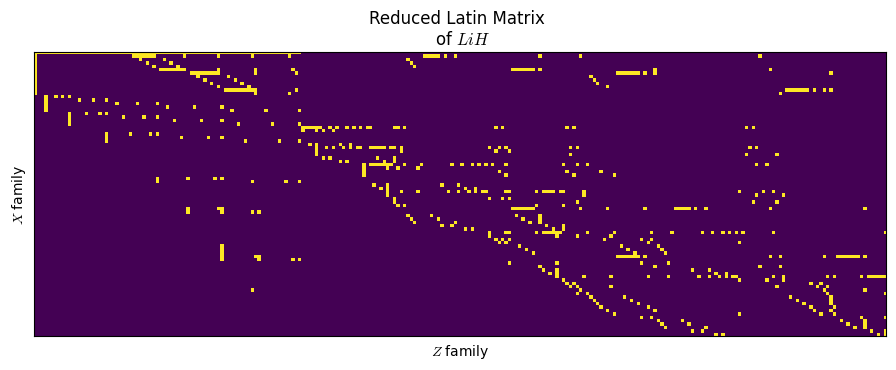

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(11,6))
ax.imshow(basis)
ax.set_title(f"Reduced Latin Matrix \n of ${MOLECULE_NAME}$")
ax.set_ylabel("$X$ family")
ax.set_xlabel("$Z$ family")
ax.tick_params(axis='both', which='both', length=0)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

plt.show()

In [31]:
edge_df = pd.DataFrame(columns=["Source", "Target"])

In [32]:
edge_df

,Source,Target


In [35]:
df.loc[2]

Pstring    IIIIIIIIIIZI
type                  0
Z          IIIIIIIIIIZI
X                  None
Znum                  2
Xnum                  0
zindex                2
xindex                0
Name: 2, dtype: object

See Eq(10) of Reggio et al

In [53]:
# Create Graph edge list
x_fam_df = df.loc[(df["zindex"] ==0) & (df["xindex"] !=0)]
z_fam_df = df.loc[(df["xindex"] ==0) & (df["zindex"] !=0)]
pro_st_df = df.loc[(df["xindex"] !=0) & (df["zindex"] !=0)]

In [60]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,561,562,629,563,512,564,630,626,610,582
Pstring,IIIIIIIIIIII,IIIIIIIIIIIZ,IIIIIIIIIIZI,IIIIIIIIIIZZ,IIIIIIIIIZII,IIIIIIIIIZIZ,IIIIIIIIIZZI,IIIIIIIIZIII,IIIIIIIIZIIZ,IIIIIIIIZIZI,...,YZZZZZZZIZYI,YZZZZZZZZIYI,YZZZZZZZYXZX,YZZZZZZZZZYI,ZYZZZZZZZZZY,YZZZZZZZZZYZ,YZZZZZZZYYZY,YZZZZZYYZZZY,YZZZYYZZZZZY,YZYYZZZZZZZY
type,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
Z,IIIIIIIIIIII,IIIIIIIIIIIZ,IIIIIIIIIIZI,IIIIIIIIIIZZ,IIIIIIIIIZII,IIIIIIIIIZIZ,IIIIIIIIIZZI,IIIIIIIIZIII,IIIIIIIIZIIZ,IIIIIIIIZIZI,...,ZZZZZZZZIZZI,ZZZZZZZZZIZI,ZZZZZZZZZIZI,ZZZZZZZZZZZI,ZZZZZZZZZZZZ,ZZZZZZZZZZZZ,ZZZZZZZZZZZZ,ZZZZZZZZZZZZ,ZZZZZZZZZZZZ,ZZZZZZZZZZZZ
X,None,None,None,None,None,None,None,None,None,None,...,XIIIIIIIIIXI,XIIIIIIIIIXI,XIIIIIIIXXIX,XIIIIIIIIIXI,IXIIIIIIIIIX,XIIIIIIIIIXI,XIIIIIIIXXIX,XIIIIIXXIIIX,XIIIXXIIIIIX,XIXXIIIIIIIX
Znum,0,1,2,3,4,5,6,8,9,10,...,4086,4090,4090,4094,4095,4095,4095,4095,4095,4095
Xnum,0,0,0,0,0,0,0,0,0,0,...,2050,2050,2061,2050,1025,2050,2061,2097,2241,2817
zindex,0,1,2,3,4,5,6,7,8,9,...,248,249,249,250,251,251,251,251,251,251
xindex,0,0,0,0,0,0,0,0,0,0,...,66,66,83,66,53,66,83,82,78,71


In [59]:
x_fam_df.T

,79,101,105,109,113,135,157,161,165,169,173,195
Pstring,IIIXIXIIIIII,IIIXXIIIIIXX,IIIXXIIIXXII,IIIXXIXXIIII,IIXIXIIIIIII,IXIXIIIIIIII,IXXIIIIIIIXX,IXXIIIIIXXII,IXXIIIXXIIII,IXXIXXIIIIII,XIXIIIIIIIII,XXIXXIIIIIII
type,1,1,1,1,1,1,1,1,1,1,1,1
Z,None,None,None,None,None,None,None,None,None,None,None,None
X,IIIXIXIIIIII,IIIXXIIIIIXX,IIIXXIIIXXII,IIIXXIXXIIII,IIXIXIIIIIII,IXIXIIIIIIII,IXXIIIIIIIXX,IXXIIIIIXXII,IXXIIIXXIIII,IXXIXXIIIIII,XIXIIIIIIIII,XXIXXIIIIIII
Znum,0,0,0,0,0,0,0,0,0,0,0,0
Xnum,320,387,396,432,640,1280,1539,1548,1584,1728,2560,3456
zindex,0,0,0,0,0,0,0,0,0,0,0,0
xindex,1,2,3,4,5,6,7,8,9,10,11,12


In [57]:
x_fam_df["zindex"].iloc[0]

0